# Proyecto II: Aprendizaje no supervisado

<strong>Estudiante:</strong> Mónica Gabriela Cabañas Meléndez 

### Importación de librerías necesarias

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

""" Factorización no negativa de matrices """
from sklearn.decomposition import NMF
import xlrd as xl

## I. Sistema de recomendación

### Importación de datos

Los siguientes datos provienen de la base de datos de MovieLens que fue recuperada por el grupo de investigación GroupLens de la Universidad de Minesotta. Esta consiste en lo siguiente:
- 65,535 calificaciones de películas que van del 1 al 5 y que han sido realizadas por 943 usuarios. 
- Por cada usuario se tiene información demográfica básica (edad, género, ocupación, y código postal)

In [54]:
ratings = pd.read_excel(
    'data/u_data_ratings.xls', 
)

print('Cantidad de ratings: ', len(ratings))
ratings.head()

Cantidad de ratings:  65535


,User ID,Item ID,Rating,Unnamed: 3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [55]:
genres = pd.read_excel(
    'data/u_movies_genre.xls', 
    header=None,
    names=['data'],
)

print('Cantidad de géneros: ', len(genres))
genres.head()

Cantidad de géneros:  19


,data
0,unknown|0
1,Action|1
2,Adventure|2
3,Animation|3
4,Children's|4


In [56]:
items = pd.read_excel(
    'data/u_movies_items.xls', 
    header=None,
    names=['data'],
)

print('Cantidad de películas: ', len(items))
items.head()

Cantidad de películas:  1682


,data
0,1|Toy Story (1995)|01-Jan-1995||http://us.imdb...
1,2|GoldenEye (1995)|01-Jan-1995||http://us.imdb...
2,3|Four Rooms (1995)|01-Jan-1995||http://us.imd...
3,4|Get Shorty (1995)|01-Jan-1995||http://us.imd...
4,5|Copycat (1995)|01-Jan-1995||http://us.imdb.c...


In [57]:
occupations = pd.read_excel(
    'data/u_occupation.xls', 
    header=None,
    names=['data'],
)

print('Cantidad de ocupaciones: ', len(occupations))
occupations.head()

Cantidad de ocupaciones:  21


,data
0,administrator
1,artist
2,doctor
3,educator
4,engineer


In [58]:
users = pd.read_excel(
    'data/u_user_info.xls', 
    header=None,
    names=['data'], 
)

print('Cantidad de usuarios: ', len(users))
users.head()

Cantidad de usuarios:  943


,data
0,1|24|M|technician|85711
1,2|53|F|other|94043
2,3|23|M|writer|32067
3,4|24|M|technician|43537
4,5|33|F|other|15213


Como podemos observar, algunos archivos (en específico users, items, y genres) contienen todos los datos en una sola columna separados por el caracter '|' por lo cual se procederá a realizar una transformación de estos datos para obtener matrices con las que podamos trabajar.

In [59]:
# Convirtiendo la información a cadena de texto y luego separando por el caracter '|'
if 'data' in users:
    users[['Id', 'Age', 'Sex', 'Occupation', 'Zip Code']] = users["data"].str.split(pat="|", expand=True)

    # Eliminando la columna 'data'
    users.drop('data', axis='columns', inplace=True)

In [60]:
print('Cantidad de usuarios: ', len(users))
users.head()

Cantidad de usuarios:  943


,Id,Age,Sex,Occupation,Zip Code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [61]:
# Convirtiendo la información a cadena de texto y luego separando por el caracter '|'
if 'data' in genres: 
    genres[['Name', 'Id']] = genres["data"].str.split(pat="|", expand=True)
    
    # Eliminando la columna 'data'
    genres.drop('data', axis='columns', inplace=True)
    genres = genres[['Id', 'Name']]

In [62]:
print('Cantidad de géneros: ', len(genres))
genres.head()

Cantidad de géneros:  19


,Id,Name
0,0,unknown
1,1,Action
2,2,Adventure
3,3,Animation
4,4,Children's


In [63]:
# Convirtiendo la información a cadena de texto y luego separando por el caracter '|'
if 'data' in items:
        items[[
                'Id', 
                'Title', 
                'Release Date', 
                'Link', 
                'Genre 0', 
                'Genre 1', 
                'Genre 2', 
                'Genre 3', 
                'Genre 4', 
                'Genre 5', 
                'Genre 6', 
                'Genre 7', 
                'Genre 8', 
                'Genre 9', 
                'Genre 10', 
                'Genre 11', 
                'Genre 12', 
                'Genre 13', 
                'Genre 14', 
                'Genre 15', 
                'Genre 16', 
                'Genre 17', 
                'Genre 18']
        ] = items["data"].str.split(pat="\\|+", expand=True)

        # Eliminando la columna 'data'
        items.drop('data', axis='columns', inplace=True)

In [64]:
print('Cantidad de películas: ', len(items))
items.head()

Cantidad de películas:  1682


,Id,Title,Release Date,Link,Genre 0,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,...,Genre 9,Genre 10,Genre 11,Genre 12,Genre 13,Genre 14,Genre 15,Genre 16,Genre 17,Genre 18
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Encontrando los grupos de perfiles de personas

Para realizar un sistema de recomendación de películas debemos primero encontrar qué perfiles existen entre las personas, y de esta manera relacionar los perfiles con los géneros y las películas. De esta manera cuando se le quiera recomendar películas a una persona esta deberá ser clasificada en algún perfil para recomendarle las películas por las cuales ese perfil tiene preferencias. Visualizaremos entonces la distribución de los datos en las diferentes variables: sexo, grupo de edad, y ocupación. Para este caso de estudio obviaremos la variable de Zip Code (código postal) ya que no nos interesa realizar grupos basados en el origen geográfico de la persona.

In [65]:
# Delimitando las edades a pocas categorías a fin de simplificar el análisis
bins = [-1, 11, 18, 30, 60, np.inf]                                         # Límites de edad
labels = ['Niños', 'Adolescentes', 'Jóvenes', 'Adultos', 'Tercera edad']    # Etiquetas

# Convertir 'Age' a numérico y aplicar pd.cut para clasificar edades
if 'Age' in users:
    users['Age Group'] = pd.cut(users['Age'].astype(int), bins=bins, labels=labels, right=True)

users.head()

,Id,Age,Sex,Occupation,Zip Code,Age Group
0,1,24,M,technician,85711,Jóvenes
1,2,53,F,other,94043,Adultos
2,3,23,M,writer,32067,Jóvenes
3,4,24,M,technician,43537,Jóvenes
4,5,33,F,other,15213,Adultos


In [66]:
if users['Id'].dtype != 'int':
    users['Id'] = users['Id'].astype(int)

# Obteniendo ratings mayores a 3
filtered_ratings = ratings[ratings['Rating'] > 3] 
# Agrupando por id de usuario para tener un arreglo de las películas que le gustaron
user_items = filtered_ratings.groupby('User ID')['Item ID'].apply(list).reset_index()

# Obteniendo los nombres de las columnas de géneros
genre_columns = [f'Genre {i}' for i in range(19)]

user_items[genre_columns] = 0

if items['Id'].dtype != 'int':
    items['Id'] = items['Id'].astype(int)

# Obteniendo los géneros de las películas que le gustaron a los usuarios
for i in range(len(user_items)):
    # Convirtiendo la lista de películas a un DataFrame
    movies = pd.DataFrame(user_items['Item ID'].loc[i], columns=['Item ID'])

    # Realizando un merge con el DataFrame de películas
    movies = pd.merge(movies, items, left_on='Item ID', right_on='Id', how='inner')
    genres_list = []

    # Iterando sobre las columnas de géneros y verificando si dicho género está presente en la película
    for genre in genre_columns:
        count_ones = movies[genre].value_counts().get('1')
        
        if count_ones is not None:
            user_items.at[i, genre] = 1
    
# Uniendo a la tabla principal de usuarios
users = pd.merge(user_items, users, left_on='User ID', right_on='Id', how='inner')

if 'User ID' in users:
    users.drop('User ID', axis='columns', inplace=True)
if 'Item ID' in users:
    users.drop('Item ID', axis='columns', inplace=True)
users.head()

,Genre 0,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,Genre 7,Genre 8,Genre 9,...,Genre 15,Genre 16,Genre 17,Genre 18,Id,Age,Sex,Occupation,Zip Code,Age Group
0,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,24,M,technician,85711,Jóvenes
1,0,1,1,1,1,1,1,0,1,0,...,1,1,1,0,2,53,F,other,94043,Adultos
2,0,1,1,0,0,1,1,1,1,0,...,1,1,1,0,3,23,M,writer,32067,Jóvenes
3,0,1,1,0,0,1,1,0,1,0,...,1,1,1,0,4,24,M,technician,43537,Jóvenes
4,0,1,1,1,1,1,1,0,1,1,...,1,1,1,1,5,33,F,other,15213,Adultos


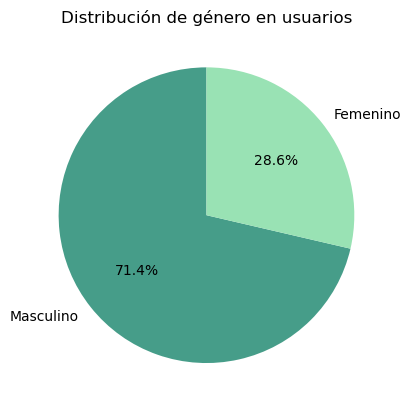

In [67]:
sex_labels = ['Masculino', 'Femenino']
sex_values = [(users['Sex'] == 'M').sum(), (users['Sex'] == 'F').sum()]

# Gráfico de pastel para género
plt.pie(x=sex_values, labels=sex_labels, autopct='%1.1f%%', startangle=90, colors=['#469D89', '#99E2B4'])
plt.title('Distribución de género en usuarios')
plt.show()

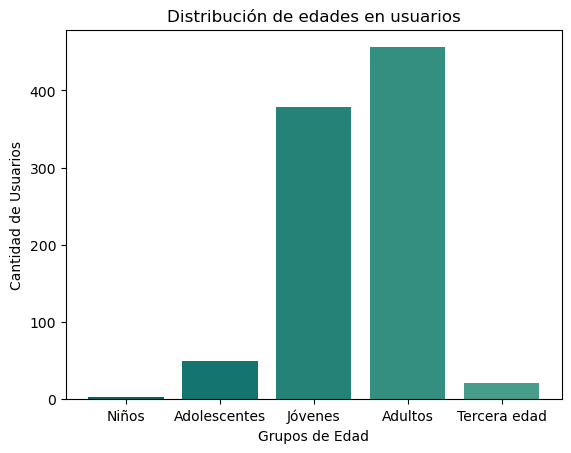

In [68]:
age_labels = ['Niños', 'Adolescentes', 'Jóvenes', 'Adultos', 'Tercera edad']
age_values = [
    (users['Age Group'] == 'Niños').sum(),
    (users['Age Group'] == 'Adolescentes').sum(),
    (users['Age Group'] == 'Jóvenes').sum(),
    (users['Age Group'] == 'Adultos').sum(),
    (users['Age Group'] == 'Tercera edad').sum()
]

# Gráfico de barras para edades
plt.bar(age_labels, age_values, color=['#036666', '#14746F', '#248277', '#358F80', '#469D89'])
plt.title('Distribución de edades en usuarios')
plt.xlabel('Grupos de Edad')
plt.ylabel('Cantidad de Usuarios')
plt.show()

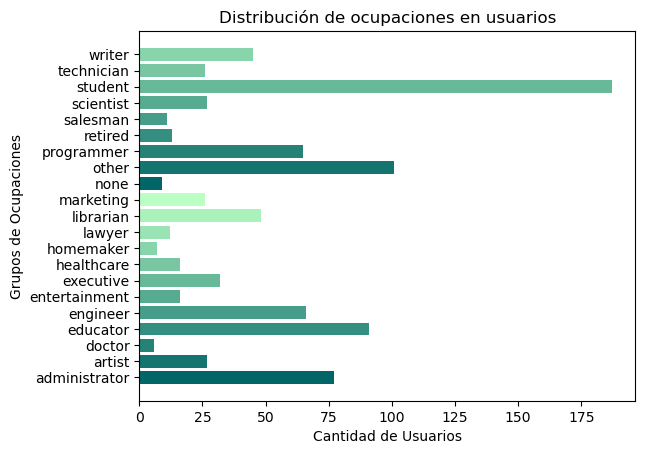

In [69]:
occupation_labels = list(occupations['data'])
occupation_values = [users['Occupation'].value_counts().get(label, 0) for label in occupation_labels]

# Gráfico de barras para ocupaciones
plt.barh(occupation_labels, occupation_values, color=['#036666', '#14746F', '#248277', '#358F80', '#469D89', '#56AB91', 
                                                      '#67B99A', '#78C7A2', '#89D5AB', '#9AE3B4', '#ABF1BC', '#BCFFC5'])
plt.title('Distribución de ocupaciones en usuarios')
plt.ylabel('Grupos de Ocupaciones')
plt.xlabel('Cantidad de Usuarios')

plt.show()

Como podemos observar a través de las gráficas anteriores la mayor cantidad de usuarios se concentra:
- Sexo: la mayoría son de sexo masculino y la minoría de sexo femenino.
- Grupo de edad: la mayoría se concentra entre los jóvenes y adultos mientras que la minoría se encuentra en el grupo de los niños y los adultos mayores.
- Ocupación: los estudiantes son la gran mayoría en este caso de estudio.

### Transformación de datos
Procederemos ahora a realizar la tranformación de los datos categóricos a numéricos para que estos puedan ser procesados por los algoritmos de procesamiento, en específico el de KMeans. Primero verificaremos que no hayan valores nulos.

In [70]:
# Verificando que no haya valores nulos
nulos = users.isnull().sum()
print(nulos)

Genre 0       0
Genre 1       0
Genre 2       0
Genre 3       0
Genre 4       0
Genre 5       0
Genre 6       0
Genre 7       0
Genre 8       0
Genre 9       0
Genre 10      0
Genre 11      0
Genre 12      0
Genre 13      0
Genre 14      0
Genre 15      0
Genre 16      0
Genre 17      0
Genre 18      0
Id            0
Age           0
Sex           0
Occupation    0
Zip Code      0
Age Group     0
dtype: int64


Dado que se trata de caracteríticas categóricas deberemos transformar los datos en algo que los algoritmos de clustering puedan manejar. Existen varias formas para realizar lo anterior: 

#### 1. Category encoding
Este término es general y abarca cualquier técnica que transforme categorías no numéricas (como "rojo", "verde", "azul") en valores numéricos que los modelos puedan procesar.
Este método puede ser contraproducente cuando se aplica en categorías no ordinales dado que introduce un enfoque de ordenamiento que no es representativo. 

#### 2. One-hot encoding
Cada categoría se transforma en una columna binaria (0 o 1) separada. Este método evita el problema de asignar un valor ordinal a categorías que no tienen un orden lógico. Se crea una matriz de 0s y 1s en la que cada fila tiene un único 1, y el resto son 0s. Sin embargo, cunado se quiere utilizar algoritmos que aplican la distancia euclidiana como KMeans este método de codificación no es muy beneficioso dado que al calcular la distancia euclideana entre dos valores siempre será la misma: $ \sqrt{2} = 1.41$

Para el caso de 3 posibles categorías: $ (1, 0, 0), (0, 1, 0) $
$$
    \sqrt{(1-0)^{2} + (0-1)^2 + (0-0)^2} = \sqrt{2} = 1.41
$$

Para el caso de 5 posibles categorías: $ (1, 0, 0, 0, 0), (0, 1, 0, 0, 0) $
$$
    \sqrt{(1-0)^{2} + (0-1)^2 + (0-0)^2 + (0-0)^2 + (0-0)^2} = \sqrt{2} = 1.41
$$

#### 3. One-over-n-hot encoding
Este método es una extensión del anterior que igualmente utiliza vectores pero en vez de asignar un 1 en el índice de la categoría correspondiente se asigna un valor entre 0 y 1 que corresponde a $\frac{1}{n}$ y de esta manera cuando se hace el cálculo de la distancia euclidiana los resultados no serán los mismos para categorías con distintos posibles valores.

Para el caso de 3 posibles categorías: $ (0.33, 0, 0), (0, 0.33, 0) $
$$
    \sqrt{(0.33-0)^{2} + (0-0.33)^2 + (0-0)^2} = 0.47
$$

Para el caso de 5 posibles categorías: $ (0.2, 0, 0, 0, 0), (0, 0.2, 0, 0, 0) $
$$
    \sqrt{(0.2-0)^{2} + (0-0.2)^2 + (0-0)^2 + (0-0)^2 + (0-0)^2} = 0.28
$$

#### 4. Equal interval encoding
Este método se puede utilizar para casos en que se traten de variables categóricas que tienen un ordenamiento subyacente como es el caso de la altura, grupos de edades, entre otros. En general, los valores asignados pueden ser calculados de la siguiente manera: 

$$
\frac{i}{(n+1)}
$$

Siendo $ i $ el índice asignado a la categoría acorde al ordenamiento subyacente. Por ejemplo, para tres posibles alturas:
- 'pequeño' = $\frac{1}{(3+1)} = 0.25$
- 'medio' = $\frac{2}{(3+1)} = 0.50$
- 'alto' = $\frac{3}{(3+1)} = 0.75$

Empezaremos entonces con la transformación de los datos, iniciando con la variable de ocupaciones que cuenta con 21 posibilidades independientes entre sí y dado que se utilizará KMeans como algoritmo de agrupamiento utilizaremos one-over-n-hot encoding.

In [71]:
# Aplicamos One-hot encoding a la columna 'Occupation'
if 'Occupation' in users:
    users = pd.get_dummies(users, columns=['Occupation'], dtype=float)

# Obteniendo el número de columnas generadas por get_dummies
num_occupations = users.filter(like='Occupation_').shape[1]

# Sustituyendo los valores 1 por 1/num_occupations y así aplicando One-over-n-hot encoding
""" for i in users[users == 1].stack().index:
    users.loc[i] = (float) (1/num_occupations) """

users.shape

(908, 45)

Para el caso del sexo que es una variable binaria aplicaremos un caso especial de one-over-n-hot encoding: Attenuated one-over-n-hot encoding el cual explica James McCafrrey en el siguiente artículo: <a href="https://visualstudiomagazine.com/Articles/2024/05/15/clustering-mixed-categorical-and-numeric-data.aspx">Clustering Mixed Categorical and Numeric Data Using k-Means with C#</a> que en varios experimentos la sola aplicación de one-over-n-hot encoding en variables binarias no se ha comportado tan bien como con attenuated encoding: <em>"In some experiments, the plain one-over-n-hot encoding for binary categorical data did not work as well as the attenuated encoding. But results were not conclusive and how best to encode binary categorical data is an open research question."</em>

Aplicando attenuated encoding en el sexo las categorías se sustituirían de la siguiente manera: 
- M = 0.5
- F = 0.0

In [72]:
for i in users[users == 'M'].stack().index:
    users.loc[i] = 1.0
    """ users.loc[i] = 0.5 """

for i in users[users == 'F'].stack().index:
    users.loc[i] = 0.0

users.head()

,Genre 0,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,Genre 7,Genre 8,Genre 9,...,Occupation_marketing,Occupation_none,Occupation_other,Occupation_programmer,Occupation_retired,Occupation_salesman,Occupation_scientist,Occupation_student,Occupation_technician,Occupation_writer
0,0,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,1,1,1,1,1,1,0,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,1,0,0,1,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,1,1,0,0,1,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,1,1,1,1,1,1,0,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Las edades, al ser valores numéricos no será necesario codificarlas, pero dado que las demás características se encuentran entre el 0 y el 1 será necesario normalizarlas con MinMax para que se encuentren en la misma escala que las demás características. A cada valor de la edad se le aplicará la siguiente expresión: 

$$
    \frac{X - X_{min}}{X_{max} - X_{min}}
$$

In [85]:
""" from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
users['Age'] = scaler.fit_transform(users['Age'].values.reshape(-1, 1)) """

# Aplicamos One-hot encoding a la columna 'Age Group'
if 'Age Group' in users:
    users = pd.get_dummies(users, columns=['Age Group'], dtype=float)

# Obteniendo el número de columnas generadas por get_dummies
num_age_groups = users.filter(like='Age Group_').shape[1]

# Sustituyendo los valores 1 por 1/num_age_groups y así aplicando One-over-n-hot encoding
""" for i in users[users == 1].stack().index:
    users.loc[i] = 1/num_age_groups """

users.head()

,Genre 0,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,Genre 7,Genre 8,Genre 9,...,Occupation_salesman,Occupation_scientist,Occupation_student,Occupation_technician,Occupation_writer,Age Group_Niños,Age Group_Adolescentes,Age Group_Jóvenes,Age Group_Adultos,Age Group_Tercera edad
0,0,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,1,1,1,1,1,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,1,1,0,0,1,1,1,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0,1,1,0,0,1,1,0,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,1,1,1,1,1,1,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [94]:
# Eliminando columnas que no se utilizarán para el análisis
if 'Id' in users:
    users.drop('Id', axis='columns', inplace=True)
if 'Age' in users:
    users.drop('Age', axis='columns', inplace=True)
if 'Zip Code' in users:
    users.drop('Zip Code', axis='columns', inplace=True)

users

,Genre 0,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,Genre 7,Genre 8,Genre 9,...,Occupation_salesman,Occupation_scientist,Occupation_student,Occupation_technician,Occupation_writer,Age Group_Niños,Age Group_Adolescentes,Age Group_Jóvenes,Age Group_Adultos,Age Group_Tercera edad
0,0,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,1,1,1,1,1,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,1,1,0,0,1,1,1,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0,1,1,0,0,1,1,0,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,1,1,1,1,1,1,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,0,0,0,1,1,1,0,0,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
904,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
905,0,0,0,1,1,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
906,0,0,0,0,0,0,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


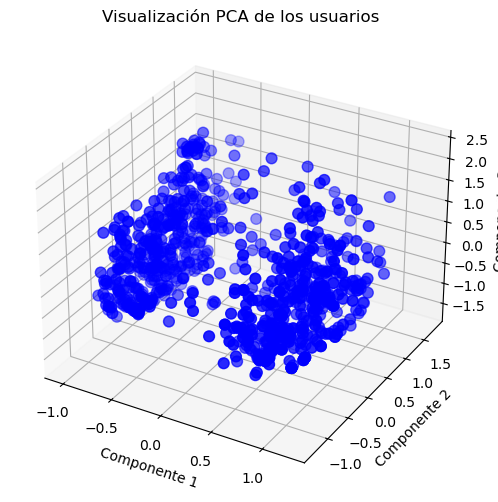

In [99]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducir a 2 dimensiones
pca = PCA(n_components=3)
pca_components = pca.fit_transform(users)

# Graficar los resultados en 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_components[:, 1], pca_components[:, 2], pca_components[:, 0], c='blue', s=60)
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
ax.set_title('Visualización PCA de los usuarios')
plt.show()

In [76]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, n_init='auto', random_state=0).fit(users)
    print('Silhouette Score para', i, 'clusters:', silhouette_score(users, kmeans.labels_))

Silhouette Score para 2 clusters: 0.143720569113964
Silhouette Score para 3 clusters: 0.1052781214251161
Silhouette Score para 4 clusters: 0.1072094203621126
Silhouette Score para 5 clusters: 0.10456639932955453
Silhouette Score para 6 clusters: 0.10625417773864579
Silhouette Score para 7 clusters: 0.10155215602510267
Silhouette Score para 8 clusters: 0.10482713137827153
Silhouette Score para 9 clusters: 0.08933377751988744
Silhouette Score para 10 clusters: 0.08731408777949849


In [91]:
from sklearn_extra.cluster import KMedoids

for i in range(2, 6):
    kmedoids = KMedoids(n_clusters=i, random_state=42, metric='manhattan').fit(users)
    print('Silhouette Score para', i, 'clusters:', silhouette_score(users, kmedoids.labels_))

Silhouette Score para 2 clusters: 0.10549496095690751
Silhouette Score para 3 clusters: 0.09771896425861079
Silhouette Score para 4 clusters: 0.07780197102811517
Silhouette Score para 5 clusters: 0.07492104870993044


In [100]:
kmedoids.labels_

array([1, 0, 0, 2, 1, 1, 1, 0, 3, 1, 0, 4, 1, 1, 0, 1, 2, 1, 0, 4, 3, 3,
       2, 2, 1, 0, 0, 0, 0, 4, 3, 2, 2, 0, 2, 2, 3, 2, 0, 0, 4, 1, 1, 3,
       2, 2, 0, 1, 3, 3, 4, 4, 2, 2, 0, 1, 2, 1, 1, 1, 0, 3, 0, 1, 1, 2,
       2, 2, 3, 1, 0, 1, 3, 0, 2, 3, 3, 3, 4, 0, 2, 1, 1, 4, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 3, 1, 3, 1, 0, 2, 0, 2, 1, 2, 3, 3, 2, 0, 0, 1, 3,
       0, 3, 0, 3, 1, 1, 2, 3, 1, 0, 0, 0, 1, 0, 4, 3, 0, 4, 0, 1, 0, 0,
       0, 0, 3, 0, 0, 1, 2, 3, 0, 2, 0, 1, 0, 1, 0, 4, 0, 2, 1, 1, 2, 3,
       0, 0, 4, 1, 4, 1, 0, 2, 0, 0, 4, 0, 1, 4, 0, 0, 0, 0, 0, 3, 2, 2,
       3, 1, 0, 4, 3, 1, 0, 1, 2, 4, 4, 3, 1, 0, 0, 0, 3, 1, 1, 0, 0, 3,
       4, 1, 1, 0, 2, 0, 0, 3, 1, 0, 0, 1, 4, 0, 1, 3, 1, 3, 2, 0, 2, 3,
       2, 1, 2, 0, 4, 2, 0, 2, 3, 3, 0, 1, 1, 1, 1, 1, 1, 4, 1, 0, 2, 0,
       1, 1, 4, 2, 2, 3, 1, 1, 2, 0, 3, 1, 2, 1, 3, 2, 3, 0, 2, 4, 1, 1,
       0, 0, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 0, 1, 1, 1, 2, 3, 2, 0, 3, 1,
       2, 0, 0, 4, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3,

### Aplicación de NMF

A continuación crearemos la matriz $V$ que estará compuesta por la combinación de los usuarios con las películas y las calificaciones serán los valores de cada celda. Cada usuario será una observación y cada película una característica. De esta manera tenemos como resultado una matriz $V$ con dimensiones $1682 \times 943$

In [77]:
user_rating_counts = ratings['User ID'].value_counts()
user_rating_counts = user_rating_counts[user_rating_counts > 0]
pd.DataFrame(user_rating_counts).shape

(916, 1)

In [78]:
item_rating_counts = ratings['Item ID'].value_counts()
pd.DataFrame(item_rating_counts).shape

(1626, 1)

No todas las películas han sido calificadas y no todos los usuarios han calificado por lo cual hay que rellenar esos espacios vacíos con 0.

In [79]:
# Crear la matriz usuario-película
user_movie_matrix = ratings.pivot_table(columns='User ID', index='Item ID', values='Rating', fill_value=0).reindex(index=range(1, 1683), columns=range(1, 944), fill_value=0)

print('Dimensiones de la matriz usuario-película: ', user_movie_matrix.shape)
user_movie_matrix.head()

Dimensiones de la matriz usuario-película:  (1682, 943)


User ID,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
Item ID,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
nmf = NMF(7)
nmf.fit(user_movie_matrix)

H = pd.DataFrame(np.round(nmf.components_,7), columns=user_movie_matrix.columns)
H.index = ['1', '2', '3', '4', '5', '6', '7']
H

User ID,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
1,0.028332,0.000000,0.000000,0.000000,0.114702,2.584991,4.132500,0.000000,0.236212,1.911167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.202765,0.963615,0.000000,0.075375,0.048451,0.325056,0.000000,0.000000,0.083938,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.709436,0.371621,0.000000,0.000000,0.248220,1.668720,0.000000,0.000000,0.110548,1.472073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.054057,0.000000,0.004833,0.000000,0.111441,0.000000,0.694531,0.000000,0.000000,0.085263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.652008,1.010878,0.695962,0.000000,0.178584,0.240510,0.174470,0.222109,0.133194,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.080228,0.000000,0.008241,0.000000,0.911242,0.000000,2.176670,0.147554,0.000000,0.047728,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.719256,0.000000,0.055978,0.238445,0.803427,0.545585,0.000000,1.546038,0.000000,0.769434,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:

W = pd.DataFrame(np.round(nmf.transform(user_movie_matrix),2), columns=H.index)
W.index = user_movie_matrix.index
W

,1,2,3,4,5,6,7
Item ID,,,,,,,
1,0.18,1.76,0.21,0.99,0.00,0.04,1.18
2,0.00,0.00,0.00,0.29,0.02,0.90,0.26
3,0.00,0.28,0.08,0.00,0.00,0.81,0.00
4,0.24,0.00,0.46,0.40,0.00,1.15,0.37
5,0.00,0.16,0.00,0.26,0.00,0.80,0.00
...,...,...,...,...,...,...,...
1678,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1679,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1680,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [82]:
reconstructed = pd.DataFrame(np.round(np.dot(W,H),2), columns=user_movie_matrix.columns)
reconstructed.index = user_movie_matrix.index
reconstructed

User ID,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
Item ID,,,,,,,,,,,,,,,,,,,,,
1,2.85,1.77,0.07,0.41,1.25,2.03,1.52,1.83,0.21,1.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.43,0.01,0.04,0.08,1.06,0.15,2.17,0.54,0.00,0.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.07,0.30,0.01,0.02,0.77,0.22,1.76,0.12,0.03,0.16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.69,0.17,0.03,0.09,1.53,1.59,3.77,0.74,0.11,1.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.91,0.15,0.01,0.01,0.77,0.05,1.92,0.12,0.01,0.06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1679,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
user_movie_matrix

User ID,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
Item ID,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
# Calculemos el error cuadrático medio de la matriz reconstruida y la original
from sklearn.metrics import mean_squared_error

mean_squared_error(user_movie_matrix, reconstructed)

0.3795382588142429

## Referencias

- https://visualstudiomagazine.com/Articles/2024/05/15/clustering-mixed-categorical-and-numeric-data.aspx
- https://jamesmccaffrey.wordpress.com/2024/04/15/clustering-categorical-data-using-k-means-with-one-over-n-hot-encoding/

## II. Cuantización de imágenes

In [10]:
from skimage import io

# Cargar la imagen
image = io.imread('Paintings/Monet.jpg')

# Normalizar los valores de los píxeles
image = image / 255.0

# Convertir la imagen a una matriz de dos dimensiones (píxeles, canales de color)
pixels = image.reshape(-1, 3)

### Visualización de los datos

In [18]:
image *255

array([[[192., 229., 245.],
        [184., 223., 240.],
        [181., 222., 240.],
        ...,
        [181., 209., 195.],
        [176., 207., 191.],
        [173., 206., 187.]],

       [[197., 234., 250.],
        [189., 228., 245.],
        [184., 225., 243.],
        ...,
        [178., 205., 196.],
        [180., 212., 199.],
        [183., 217., 201.]],

       [[197., 234., 250.],
        [191., 230., 247.],
        [184., 227., 244.],
        ...,
        [172., 201., 196.],
        [176., 207., 201.],
        [180., 213., 206.]],

       ...,

       [[107., 145., 216.],
        [102., 136., 210.],
        [110., 142., 219.],
        ...,
        [108., 127., 169.],
        [118., 125., 169.],
        [105.,  99., 147.]],

       [[112., 152., 214.],
        [ 99., 136., 204.],
        [102., 136., 208.],
        ...,
        [114., 133., 173.],
        [122., 126., 171.],
        [104.,  98., 144.]],

       [[108., 145., 216.],
        [ 98., 132., 206.],
        [ 98., 1

In [15]:
from sklearn.cluster import KMeans

# Definir el número de clusters (colores deseados)
num_clusters = 5

# Aplicar K-means
kmeans = KMeans(n_clusters=num_clusters, n_init='auto', random_state=0)
kmeans.fit(pixels)

# Obtener los colores medios y las etiquetas de cada cluster
colors = kmeans.cluster_centers_
labels = kmeans.labels_

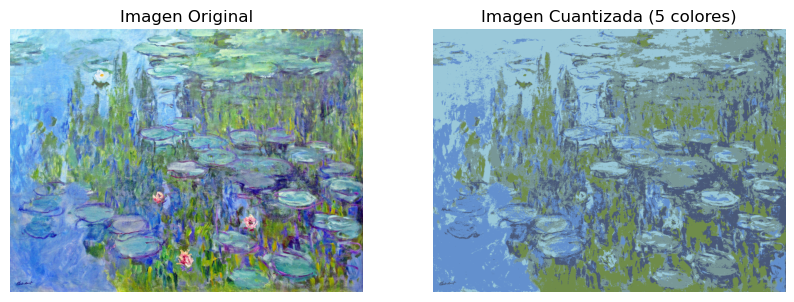

In [16]:
import matplotlib.pyplot as plt

# Reemplazar cada píxel con el color del cluster al que pertenece
quantized_image = colors[labels].reshape(image.shape)

# Mostrar la imagen original y la imagen cuantizada
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Imagen original
ax[0].imshow(image)
ax[0].set_title('Imagen Original')
ax[0].axis('off')

# Imagen cuantizada
ax[1].imshow(quantized_image)
ax[1].set_title(f'Imagen Cuantizada ({num_clusters} colores)')
ax[1].axis('off')

plt.show()